In [1]:
cd /home/panos/jeodpp.jrc.ec.europa.eu/jeodpp.jrc.ec.europa.eu/ftp/private/zyWUYa4wk/nxGGjsuRHYrOuTx1/output-ftp/mavropa/sla/

/home/panos/jeodpp.jrc.ec.europa.eu/jeodpp.jrc.ec.europa.eu/ftp/private/zyWUYa4wk/nxGGjsuRHYrOuTx1/output-ftp/mavropa/sla


In [2]:
ls

 dataset-duacs-rep-global-alg-phy-l3/   dataset-duacs-rep-global-j2g-phy-l3/
 dataset-duacs-rep-global-al-phy-l3/    dataset-duacs-rep-global-j2n-phy-l3/
 dataset-duacs-rep-global-c2-phy-l3/    dataset-duacs-rep-global-j2-phy-l3/
 dataset-duacs-rep-global-e1g-phy-l3/   dataset-duacs-rep-global-j3-phy-l3/
 dataset-duacs-rep-global-e1-phy-l3/    dataset-duacs-rep-global-s3a-phy-l3/
 dataset-duacs-rep-global-e2-phy-l3/    index.html
 dataset-duacs-rep-global-enn-phy-l3/  'index.html?C=D;O=A'
 dataset-duacs-rep-global-en-phy-l3/   'index.html?C=D;O=D'
 dataset-duacs-rep-global-g2-phy-l3/   'index.html?C=M;O=A'
 dataset-duacs-rep-global-h2g-phy-l3/  'index.html?C=M;O=D'
 dataset-duacs-rep-global-h2-phy-l3/   'index.html?C=N;O=A'
 dataset-duacs-rep-global-j1g-phy-l3/  'index.html?C=N;O=D'
 dataset-duacs-rep-global-j1n-phy-l3/  'index.html?C=S;O=A'
 dataset-duacs-rep-global-j1-phy-l3/   'index.html?C=S;O=D'


In [3]:
import glob 

import numpy as np
import pandas as pd
import xarray as xr

np.set_printoptions(linewidth=200)

In [4]:
SATELLITES = [
    "alg", "al", "c2", "e1g", "e1", "e2", "enn", "en", "g2", "h2g", "h2", "j1g", "j1n", "j1", "j2g", "j2n", "j2", "j3", "s3a",
]

In [5]:
%%time 

def normalize_ds(ds: xr.Dataset, satellite: str) -> xr.Dataset:
    ds = (
        ds
        .reset_coords("latitude")
        .reset_coords("longitude")
        .assign(satellite=satellite)
        .expand_dims("satellite")
        .set_coords("satellite")
    )
    return ds

def get_day_dataset(path: str, columns: list[str]): 
    day = pd.to_datetime(path.rsplit("_", 2)[1])
    ds = xr.open_dataset(path).sel(time=slice(day, day + pd.DateOffset(1)))
    ds = ds[columns]
    return ds

def get_satellite_dataset(satellite: str, columns: list[str], base_dir: str = "") -> xr.Dataset:
    if base_dir:
        assert base_dir.endswith("/"), "The base_dir must end in a /"
    paths = sorted(glob.glob(f"{base_dir}dataset-duacs-rep-global-{satellite}-phy-l3/????/??/*.nc"))
    day_datasets = (get_day_dataset(path, columns=columns) for path in paths) 
    ds = normalize_ds(xr.concat(day_datasets, dim="time"), satellite=satellite)
    return ds

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 6.91 µs


In [ ]:
%%time
j2 = get_satellite_dataset(
    satellite="j2",
    columns=["longitude", "latitude", "sla_unfiltered"],
    base_dir="/home/panos/jeodpp.jrc.ec.europa.eu/jeodpp.jrc.ec.europa.eu/ftp/private/zyWUYa4wk/nxGGjsuRHYrOuTx1/output-ftp/mavropa/sla/",
)

In [11]:
j2

<xarray.Dataset>
Dimensions:         (time: 99820890, satellite: 1)
Coordinates:
  * time            (time) datetime64[ns] 2002-12-28T00:00:00.656359680 ... 2...
  * satellite       (satellite) <U2 'j1'
Data variables:
    latitude        (satellite, time) float64 39.83 39.79 39.74 ... -56.8 -56.84
    longitude       (satellite, time) float64 0.9808 1.016 1.051 ... 331.4 331.5
    sla_unfiltered  (satellite, time) float32 0.1 0.029 0.013 ... -0.014 -0.015
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H20M28.965852S
    time_coverage_end:               2002-12-28T23:07:05Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2002-12-27T23:46:36Z
    title:                           DT Jason-1 Global Ocean Along track SSAL...

In [7]:
for sat in SATELLITES:
    for year in range(1993, 2020):
        for month in range(1, 13):
            try:
                ds = get_satellite_dataset(sat, year=year, month=month)
            except OSError:
                pass
                #print(sat, year, month, "NO")
            except ValueError:
                print(sat, year, month)
    print(sat)

alg 2015 8


KeyboardInterrupt: 

In [8]:
ds = get_satellite_dataset("alg", 2015, 8)

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [9]:
import pathlib
previous = None
for i, nc in enumerate(sorted(pathlib.Path("dataset-duacs-rep-global-alg-phy-l3/2015/08/").glob("*.nc"))):
    if i > 0:
        previous = ds.time.values[-5:]
        previous_lat = ds.latitude.values[-5:]
        previous_lon = ds.longitude.values[-5:]
    ds = xr.open_dataset(nc)
    current = ds.time.values[:5]
    if i > 0:
        if previous[-1] > current[0]:
            print(str(nc))
            print(previous)
            print(current)
            print()
            break

dataset-duacs-rep-global-alg-phy-l3/2015/08/dt_global_alg_phy_l3_20150826_20190101.nc
['2015-08-25T23:16:52.160473088' '2015-08-25T23:16:53.216473088' '2015-08-25T23:16:54.272473088' '2015-08-25T23:16:55.328473344' '2015-08-25T23:16:56.384473344']
['2015-08-25T23:16:42.080080896' '2015-08-25T23:16:43.136080896' '2015-08-25T23:16:44.192080896' '2015-08-25T23:16:45.248080896' '2015-08-25T23:16:46.304080640']



In [10]:
ds25 = xr.open_dataset("dataset-duacs-rep-global-alg-phy-l3/2015/08/dt_global_alg_phy_l3_20150825_20190101.nc")
ds26 = xr.open_dataset("dataset-duacs-rep-global-alg-phy-l3/2015/08/dt_global_alg_phy_l3_20150826_20190101.nc")

In [28]:
ds26.time[~(ds26.time.dt.day == 25)]

<xarray.DataArray 'time' (time: 44211)>
array(['2015-08-26T00:00:00.896080896', '2015-08-26T00:00:01.952080896',
       '2015-08-26T00:00:03.008080896', ..., '2015-08-26T23:28:41.889888000',
       '2015-08-26T23:28:42.945888000', '2015-08-26T23:28:44.001888000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2015-08-26T00:00:00.896080896 ... 2015-0...
    longitude  (time) float64 254.4 254.3 254.3 254.2 ... 261.3 261.2 261.2
    latitude   (time) float64 -62.36 -62.42 -62.48 ... -63.56 -63.61 -63.67
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

In [30]:
ds26.time.sel(time=slice("2015-08-25T00:00:00", "2015-08-26T00:00:00"))

<xarray.DataArray 'time' (time: 1736)>
array(['2015-08-25T23:16:42.080080896', '2015-08-25T23:16:43.136080896',
       '2015-08-25T23:16:44.192080896', ..., '2015-08-25T23:59:58.784080896',
       '2015-08-25T23:59:59.840080896', '2015-08-26T00:00:00.896080896'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2015-08-25T23:16:42.080080896 ... 2015-0...
    longitude  (time) float64 11.67 11.24 10.82 10.39 ... 254.5 254.4 254.4
    latitude   (time) float64 81.5 81.5 81.5 81.5 ... -62.18 -62.24 -62.3 -62.36
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

In [11]:
for i in range(-15, 0):
    print("%s\t%.6f\t%.6f" % (ds25.time.values[i], ds25.longitude.values[i], ds25.latitude.values[i]))
print()
for i in range(0, 8):
    print("%s\t%.6f\t%.6f" % (ds26.time.values[i], ds26.longitude.values[i], ds26.latitude.values[i]))

2015-08-25T23:16:41.600473088	17.820407	81.454591
2015-08-25T23:16:42.656473088	17.399532	81.460908
2015-08-25T23:16:43.712473088	16.978066	81.466780
2015-08-25T23:16:44.768473088	16.556051	81.472206
2015-08-25T23:16:45.824473088	16.133529	81.477185
2015-08-25T23:16:46.880473088	15.710545	81.481717
2015-08-25T23:16:47.936473344	15.287140	81.485799
2015-08-25T23:16:48.992473344	14.863359	81.489433
2015-08-25T23:16:50.048473088	14.439243	81.492617
2015-08-25T23:16:51.104473088	14.014839	81.495350
2015-08-25T23:16:52.160473088	13.590187	81.497633
2015-08-25T23:16:53.216473088	13.165334	81.499465
2015-08-25T23:16:54.272473088	12.740323	81.500845
2015-08-25T23:16:55.328473344	12.315198	81.501774
2015-08-25T23:16:56.384473344	11.890004	81.502251

2015-08-25T23:16:42.080080896	11.666765	81.502321
2015-08-25T23:16:43.136080896	11.241552	81.502109
2015-08-25T23:16:44.192080896	10.816380	81.501446
2015-08-25T23:16:45.248080896	10.391452	81.500331
2015-08-25T23:16:46.304080640	9.966715	81.498766


In [259]:
ds25.values?

Signature: ds25.values()
Docstring: D.values() -> an object providing a view on D's values
File:      ~/.conda/envs/thalassa_dev/lib/python3.9/_collections_abc.py
Type:      method


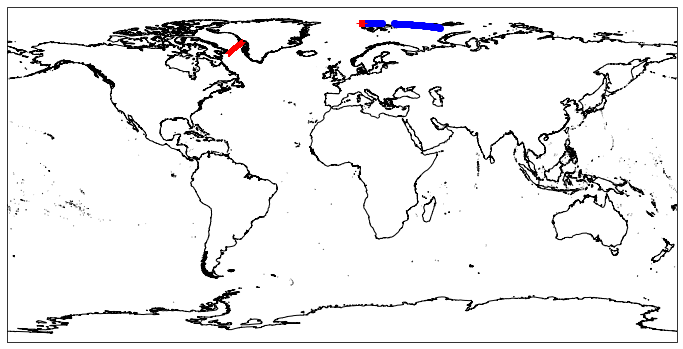

In [22]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

projection = ccrs.PlateCarree();
#projection=ccrs.Geostationary()
#projection = ccrs.InterruptedGoodeHomolosine()

num = 100
fig, axes = plt.subplots(1, 1, figsize=(12, 8), subplot_kw=dict(projection=projection))

axes.set_global()
axes.coastlines(resolution='10m');
#axes.plot(ds25.longitude[-15:], ds25.latitude[-15:], "bo", transform=projection);
#axes.plot(ds25.longitude, ds25.latitude, "bo", transform=projection);
axes.plot(ds25.longitude[-num:], ds25.latitude[-num:], "bo", transform=projection);
axes.plot(ds26.longitude[:num], ds26.latitude[:num], "r+", transform=projection);
plt.show()

In [373]:
%matplotlib widget

In [265]:
ds25.plot.streamplot?
#ds25[["longitude", "latitude"]].plot.

Signature: ds25.plot.streamplot(x, y, ax, u, v, **kwargs)
Docstring:
Plot streamlines of Dataset variables.

Wraps :py:func:`matplotlib:matplotlib.pyplot.streamplot`.


Parameters
----------

ds : Dataset
x, y : str
    Variable names for the *x* and *y* grid positions.
u, v : str, optional
    Variable names for the *u* and *v* velocities
    (in *x* and *y* direction, respectively; quiver/streamplot plots only).
hue: str, optional
    Variable by which to color scatter points or arrows.
hue_style: {'continuous', 'discrete'}, optional
    How to use the ``hue`` variable:

    - ``'continuous'`` -- continuous color scale
      (default for numeric ``hue`` variables)
    - ``'discrete'`` -- a color for each unique value, using the default color cycle
      (default for non-numeric ``hue`` variables)
markersize: str, optional
    Variable by which to vary the size of scattered points (scatter plot only).
size_norm: matplotlib.colors.Normalize or tuple, optional
    Used to normalize the 

In [ ]:
ds25[["longitude", "latitude"]].values

In [242]:
ds25.info()

xarray.Dataset {
dimensions:
	time = 43702 ;

variables:
	datetime64[ns] time(time) ;
		time:axis = T ;
		time:long_name = Time of measurement ;
		time:standard_name = time ;
	float64 longitude(time) ;
		longitude:long_name = Longitude of measurement ;
		longitude:standard_name = longitude ;
		longitude:units = degrees_east ;
	float64 latitude(time) ;
		latitude:long_name = Latitude of measurement ;
		latitude:standard_name = latitude ;
		latitude:units = degrees_north ;
	int16 cycle(time) ;
		cycle:long_name = Cycle the measurement belongs to ;
		cycle:units = 1 ;
	int16 track(time) ;
		track:long_name = Track in cycle the measurement belongs to ;
		track:units = 1 ;
	float32 dac(time) ;
		dac:comment = The sla in this file is already corrected for the dac; the uncorrected sla can be computed as follows: [uncorrected sla]=[sla from product]+[dac]; see the product user manual for details ;
		dac:long_name = Dynamic Atmospheric Correction ;
		dac:units = m ;
	float32 lwe(time) ;
		lwe:c

In [190]:
e1 = datasets["e1"]
e2 = datasets["e2"]
j1 = datasets["e1"]
j2 = datasets["e2"]
j3 = datasets["e2"]
e1
e2

<xarray.Dataset>
Dimensions:         (time: 661514, satellite: 1)
Coordinates:
  * time            (time) datetime64[ns] 1995-04-30T23:43:00.167305472 ... 1...
  * satellite       (satellite) <U2 'e1'
Data variables:
    longitude       (satellite, time) float64 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    latitude        (satellite, time) float64 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    cycle           (satellite, time) int16 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    track           (satellite, time) int16 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    dac             (satellite, time) float32 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    lwe             (satellite, time) float32 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    mdt             (satellite, time) float32 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    ocean_tide      (satellite, time) float64 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    sla_filtered    (satellite, time) float32 dask.array<chunksize=(1, 46613), meta=np.ndarray>
    sla_unfiltered  (satellite, time) float32 dask.array<chunksize=(1, 46613), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H3M56.917259S
    time_coverage_end:               1995-05-01T23:46:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             1995-04-30T23:43:00Z
    title:                           DT ERS-1 Global Ocean Along track SSALTO...

<xarray.Dataset>
Dimensions:         (time: 680568, satellite: 1)
Coordinates:
  * time            (time) datetime64[ns] 1995-05-15T22:11:19.390423040 ... 1...
  * satellite       (satellite) <U2 'e2'
Data variables:
    longitude       (satellite, time) float64 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    latitude        (satellite, time) float64 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    cycle           (satellite, time) int16 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    track           (satellite, time) int16 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    dac             (satellite, time) float32 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    lwe             (satellite, time) float32 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    mdt             (satellite, time) float32 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    ocean_tide      (satellite, time) float64 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    sla_filtered    (satellite, time) float32 dask.array<chunksize=(1, 3800), meta=np.ndarray>
    sla_unfiltered  (satellite, time) float32 dask.array<chunksize=(1, 3800), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P1H26M57.756509S
    time_coverage_end:               1995-05-15T23:38:17Z
    time_coverage_resolution:        P1S
    time_coverage_start:             1995-05-15T22:11:19Z
    title:                           DT ERS-2 Global Ocean Along track SSALTO...

In [72]:
mds = xr.merge([e1, e2], compat="override")

In [156]:
e1.time[-10:]
e2.time[:10]

<xarray.DataArray 'time' (time: 10)>
array(['1995-05-15T20:38:32.560354304', '1995-05-15T20:38:33.540354560',
       '1995-05-15T20:38:34.520354560', '1995-05-15T20:38:35.500354560',
       '1995-05-15T20:38:36.480354304', '1995-05-15T20:38:37.460354304',
       '1995-05-15T20:38:38.440354304', '1995-05-15T20:38:39.420354304',
       '1995-05-15T20:38:40.400354304', '1995-05-15T20:38:41.380354304'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-05-15T20:38:32.560354304 ... 1995-05-...
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

<xarray.DataArray 'time' (time: 10)>
array(['1995-05-15T22:11:19.390423040', '1995-05-15T22:11:20.370423040',
       '1995-05-15T22:11:21.350423040', '1995-05-15T22:11:22.330423040',
       '1995-05-15T22:11:23.310423040', '1995-05-15T22:11:24.290422784',
       '1995-05-15T22:11:25.270422784', '1995-05-15T22:11:26.250422784',
       '1995-05-15T22:11:27.230423040', '1995-05-15T22:11:28.210423040'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-05-15T22:11:19.390423040 ... 1995-05-...
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

In [153]:
e1.sla_unfiltered[0, :10].values
e2.sla_unfiltered[0, :10].values
mds.sla_unfiltered[:, :10].values

<xarray.DataArray 'time' (time: 10)>
array(['1995-04-30T23:43:00.167305472', '1995-04-30T23:43:01.147305472',
       '1995-04-30T23:43:02.127305472', '1995-04-30T23:43:03.107305472',
       '1995-04-30T23:43:04.087305472', '1995-04-30T23:43:05.067305472',
       '1995-04-30T23:43:06.047305216', '1995-04-30T23:43:07.027305728',
       '1995-04-30T23:43:08.007305472', '1995-04-30T23:43:08.987305472'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-04-30T23:43:00.167305472 ... 1995-04-...
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

<xarray.DataArray 'time' (time: 10)>
array(['1995-05-15T22:11:19.390423040', '1995-05-15T22:11:20.370423040',
       '1995-05-15T22:11:21.350423040', '1995-05-15T22:11:22.330423040',
       '1995-05-15T22:11:23.310423040', '1995-05-15T22:11:24.290422784',
       '1995-05-15T22:11:25.270422784', '1995-05-15T22:11:26.250422784',
       '1995-05-15T22:11:27.230423040', '1995-05-15T22:11:28.210423040'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-05-15T22:11:19.390423040 ... 1995-05-...
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

array([-0.071, -0.12 , -0.074, -0.042, -0.066, -0.035, -0.048, -0.083, -0.063, -0.04 ], dtype=float32)

array([-0.041     , -0.06900001, -0.057     , -0.039     , -0.054     , -0.039     , -0.074     , -0.027     , -0.027     , -0.005     ], dtype=float32)

array([[-0.071, -0.12 , -0.074, -0.042, -0.066, -0.035, -0.048, -0.083, -0.063, -0.04 ],
       [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan]], dtype=float32)

In [151]:
import pandas as pd
mds.sel(dict(time=slice("1995-05-01T01:50:00", "1995-05-01T02:03:00"))).dac.values[:, :499]

array([[-4.71999981e-02, -4.76999991e-02, -4.80999984e-02, -4.83999997e-02, -4.86999974e-02, -4.91000004e-02, -4.93999980e-02, -4.96999994e-02, -4.98999991e-02, -5.08999974e-02, -5.26999980e-02,
        -5.43999970e-02, -5.61999977e-02, -5.76999970e-02, -5.82999997e-02, -5.88999987e-02, -5.95999993e-02, -6.03999980e-02, -6.01999983e-02, -5.95999993e-02, -5.90000004e-02, -5.83999977e-02,
        -5.79000004e-02, -5.74999973e-02, -5.72999977e-02, -5.70000000e-02, -5.66999987e-02, -5.61999977e-02, -5.57999983e-02, -5.53999990e-02, -5.49999997e-02, -5.46000004e-02, -5.42999990e-02,
        -5.38999997e-02, -5.35999984e-02, -5.33999987e-02, -5.30999973e-02, -5.28999977e-02, -5.26000001e-02, -5.22999987e-02, -5.19999973e-02, -5.16999997e-02, -5.13999984e-02, -5.10999970e-02,
        -5.07999994e-02, -5.05999997e-02, -5.02999984e-02, -4.99999970e-02, -4.97999974e-02, -4.94999997e-02, -4.93000001e-02, -4.89999987e-02, -4.87999991e-02, -4.85999994e-02, -4.82999980e-02,
        -4.80999984e-02, 